<a href="https://colab.research.google.com/github/vimesh630/Revenue_Forecasting/blob/main/XGBoost_for_Revenue_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

#2. Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3. Load Data

In [3]:
train_path='/content/drive/MyDrive/VERGER/Revenue_Forecasting/train_forecast_data.csv'
test_path='/content/drive/MyDrive/VERGER/Revenue_Forecasting/test_forecast_data.csv'

train_df=pd.read_csv(train_path)
test_df=pd.read_csv(test_path)

#4. Define Features and Target

In [4]:
features = ['Account', 'Product', 'Type',
            'Lag_Qty_1', 'Lag_Qty_2', 'Lag_Rev_1', 'Lag_Rev_2',
            'Rolling_Qty_3', 'Rolling_Rev_3']

target_revenue = 'Forecast_Revenue'

# Drop rows with missing values in features or target
train_df = train_df.dropna(subset=features + [target_revenue])
test_df = test_df.dropna(subset=features + [target_revenue])

X_train = train_df[features]
X_test = test_df[features]

y_train = train_df[target_revenue]
y_test = test_df[target_revenue]

#5. Column Transformer for Categorical Features

In [5]:
categorical_features = ['Account', 'Product', 'Type']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as is
)

#6. XGBoost Regressor in Pipeline

In [6]:
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

#7. Train the Model

In [7]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Account', 'Product',
                                                   'Type'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_c...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, ...))])

#8. Evaluate the Model

In [9]:
y_pred = pipeline.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)**0.5 # Calculate RMSE by taking the square root
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n XGBoost Revenue Forecasting Results:")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAE : {mae:,.2f}")
print(f"  R²  : {r2:.4f}")


 XGBoost Revenue Forecasting Results:
  RMSE: 29,725.82
  MAE : 11,679.73
  R²  : -0.2459


#9. Feature Importace Plot

<Figure size 1000x600 with 0 Axes>

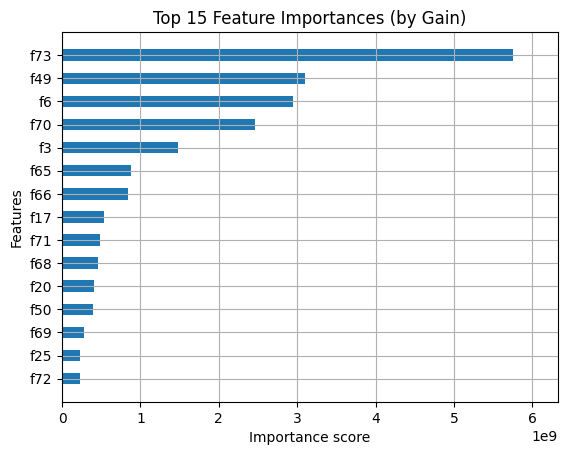

In [10]:
# Extract feature names after one-hot encoding
onehot_feature_names = pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'].get_feature_names_out(categorical_features)

all_feature_names = list(onehot_feature_names) + [f for f in features if f not in categorical_features]

# Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(
    pipeline.named_steps['regressor'],
    importance_type='gain',
    show_values=False,
    height=0.5,
    max_num_features=15
)
plt.title('Top 15 Feature Importances (by Gain)')
plt.show()